# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [63]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [64]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [65]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('Shape of azdias dataset: ', azdias.shape)

print('First 5 rows of azdias dataset: ')

azdias.head(5)



Shape of azdias dataset:  (891221, 85)
First 5 rows of azdias dataset: 


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [66]:
print('Description of azdias dataset: ')
azdias.describe()

Description of azdias dataset: 


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [67]:
print('Feature summary in azdias dataset:')

print('Shape of feat_info: ', feat_info.shape)

print('First 5 rows of feat_info: ')

feat_info.head(5)

Feature summary in azdias dataset:
Shape of feat_info:  (85, 4)
First 5 rows of feat_info: 


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [68]:

print('Description of feat_info: ')

feat_info.describe()

Description of feat_info: 


,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,KBA05_ANTG4,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [69]:

# Found the following special weird characters in the missing_values column
missing_values_special_characters = ['', 'X', 'XX']

def process_missing_values_list(list_of_missing_values_as_string):
    """
    In this function, we will process missing value and fix its format from list as string to list of integers
    """
    # First, we will remove the brackets
    missing_values_list_without_brackets = list_of_missing_values_as_string.strip('[').strip(']')
    # Then, we will split the list to list of integers numbers saved as string
    missing_values_list_seperated = missing_values_list_without_brackets.split(sep=',')
    # After that, we will convert all the missing_values_list_to_integers
    processed_missing_values_list = []
    
    for missing_value in missing_values_list_seperated:
        # Do not include special characters to the processed missing values list
        if missing_value in missing_values_special_characters:
            processed_missing_values_list.append(missing_value)
        else:
            # Otherwise, value is a number and can be saved as integer
            processed_missing_values_list.append(int(missing_value))

    # Note that we found some special characters in the missing_of_unknown column
    # We will remove them from the processed_missing_values as we will manually check from them later
    
    return processed_missing_values_list



In [70]:
# Create a column from 'missing_or_unknown' but in a correct format to use later
feat_info['processed_missing_or_unknown'] = feat_info.apply(
    lambda row: process_missing_values_list(row['missing_or_unknown']), axis=1
)


In [71]:
feat_info.head(10)

,attribute,information_level,type,missing_or_unknown,processed_missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]
5,FINANZ_SPARER,person,ordinal,[-1],[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1],[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1],[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1],[-1]


In [72]:
# Example of 'processed_missing_or_unknown' values (array of integers)
feat_info.iloc[0]['processed_missing_or_unknown']

[-1, 0]

In [73]:
for index in range(len(feat_info)):
    # Retrieve data of feat_info with given index
    feature_info_details = feat_info.iloc[index]
    print('Processing for column "{}", with missing values {}'.format(feature_info_details['attribute'], feature_info_details['processed_missing_or_unknown']))

    # Check for any missing values
    # Do not do anything for no missing values
    if feature_info_details['processed_missing_or_unknown'] == []:
        print('No missing value found...')
        continue
    
    # Change missing values to np.nan
    azdias = azdias.replace({feature_info_details['attribute']: feature_info_details['processed_missing_or_unknown']}, np.nan)

Processing for column "AGER_TYP", with missing values [-1, 0]
Processing for column "ALTERSKATEGORIE_GROB", with missing values [-1, 0, 9]
Processing for column "ANREDE_KZ", with missing values [-1, 0]
Processing for column "CJT_GESAMTTYP", with missing values [0]
Processing for column "FINANZ_MINIMALIST", with missing values [-1]
Processing for column "FINANZ_SPARER", with missing values [-1]
Processing for column "FINANZ_VORSORGER", with missing values [-1]
Processing for column "FINANZ_ANLEGER", with missing values [-1]
Processing for column "FINANZ_UNAUFFAELLIGER", with missing values [-1]
Processing for column "FINANZ_HAUSBAUER", with missing values [-1]
Processing for column "FINANZTYP", with missing values [-1]
Processing for column "GEBURTSJAHR", with missing values [0]
Processing for column "GFK_URLAUBERTYP", with missing values ['']
Processing for column "GREEN_AVANTGARDE", with missing values ['']
Processing for column "HEALTH_TYP", with missing values [-1, 0]
Processing for

In [74]:
# Identify missing or unknown data values and convert them to NaNs.

def show_columns_with_null_values(df):
    columns_with_null_values = df.isnull().sum()

    for column_label, null_values_count in columns_with_null_values.items():
        # Do not include non-null columns
        if(null_values_count == 0):
            continue

        print('Column Name: ', column_label)
        print('Null Values Count: ', null_values_count, '\n')

show_columns_with_null_values(azdias)

Column Name:  AGER_TYP
Null Values Count:  685843 

Column Name:  ALTERSKATEGORIE_GROB
Null Values Count:  2881 

Column Name:  CJT_GESAMTTYP
Null Values Count:  4854 

Column Name:  GEBURTSJAHR
Null Values Count:  392318 

Column Name:  GFK_URLAUBERTYP
Null Values Count:  4854 

Column Name:  HEALTH_TYP
Null Values Count:  111196 

Column Name:  LP_LEBENSPHASE_FEIN
Null Values Count:  97632 

Column Name:  LP_LEBENSPHASE_GROB
Null Values Count:  94572 

Column Name:  LP_FAMILIE_FEIN
Null Values Count:  77792 

Column Name:  LP_FAMILIE_GROB
Null Values Count:  77792 

Column Name:  LP_STATUS_FEIN
Null Values Count:  4854 

Column Name:  LP_STATUS_GROB
Null Values Count:  4854 

Column Name:  NATIONALITAET_KZ
Null Values Count:  108315 

Column Name:  PRAEGENDE_JUGENDJAHRE
Null Values Count:  108164 

Column Name:  RETOURTYP_BK_S
Null Values Count:  4854 

Column Name:  SHOPPER_TYP
Null Values Count:  111196 

Column Name:  SOHO_KZ
Null Values Count:  73499 

Column Name:  TITEL_KZ
Null

In [75]:

# Total number of null values in the dataset after changing missing data to np.nan
print('Total number of null values in the dataset: ', azdias.isnull().sum().sum())

Total number of null values in the dataset:  8373929


In [76]:
def show_columns_with_no_missing_values(df):
    counter = 0
    for column_name, null_values_count in df.isnull().sum().items():
        if(null_values_count > 0):
            continue
        counter += 1
        print(counter, '. ', column_name)
    
    print('\n\n', 'Columns with no null values count: ', counter)

show_columns_with_no_missing_values(azdias)

1 .  ANREDE_KZ
2 .  FINANZ_MINIMALIST
3 .  FINANZ_SPARER
4 .  FINANZ_VORSORGER
5 .  FINANZ_ANLEGER
6 .  FINANZ_UNAUFFAELLIGER
7 .  FINANZ_HAUSBAUER
8 .  FINANZTYP
9 .  GREEN_AVANTGARDE
10 .  SEMIO_SOZ
11 .  SEMIO_FAM
12 .  SEMIO_REL
13 .  SEMIO_MAT
14 .  SEMIO_VERT
15 .  SEMIO_LUST
16 .  SEMIO_ERL
17 .  SEMIO_KULT
18 .  SEMIO_RAT
19 .  SEMIO_KRIT
20 .  SEMIO_DOM
21 .  SEMIO_KAEM
22 .  SEMIO_PFLICHT
23 .  SEMIO_TRADV
24 .  ZABEOTYP


 Columns with no null values count:  24


We will remove all the columns containing null values.

Please note that FINANZTYP is redundant column as we have the details of each financial type in the previous columns, so we will also remove FINANZTYP column.

As some columns we have contains null values, we will remove those columns to ease the process of fining patterns of potential clients.

Sometimes we consider changing their values but in this case, we will just remove them.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [77]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

number_of_missing_data_for_each_column = azdias.isnull().sum()

percent_of_missing_data_for_each_column = (number_of_missing_data_for_each_column/azdias.shape[0]) * 100


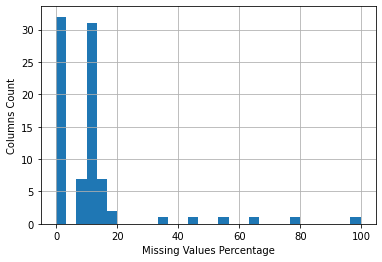

In [78]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(percent_of_missing_data_for_each_column.values, bins=30)
plt.xlabel('Missing Values Percentage')
plt.ylabel('Columns Count')
plt.grid(True)
plt.show()

In [79]:
outlier_columns_above_20_percent = percent_of_missing_data_for_each_column[percent_of_missing_data_for_each_column > 20]

print('Number of outlier columns: ', len(outlier_columns_above_20_percent), '\n')

print('Outlier column details:\n', outlier_columns_above_20_percent)

Number of outlier columns:  6 

Outlier column details:
 AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64


In [80]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# We are gonna remove the outlier columns as we observed from the above histogram
# We found that there are 6 outlier columns
columns_to_be_dropped = outlier_columns_above_20_percent.index.tolist()
print('Dropping the following outlier columns: {}'.format(columns_to_be_dropped))

azdias_modified = azdias.drop(columns_to_be_dropped, axis=1)



Dropping the following outlier columns: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [81]:
print('Dataset\'s shape after removal of outlier columns: ', azdias_modified.shape)

Dataset's shape after removal of outlier columns:  (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

As we observed from the plotted histogram, we have 6 columns that were outliers so we will remove them from the dataset as they contain less than 20% of non-null values. Columns that were removed: ('AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX').


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

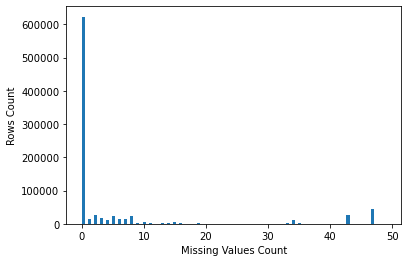

In [82]:
# How much data is missing in each row of the dataset?
missing_data_per_row = azdias_modified.isnull().sum(axis=1)

# We are gonna use (hist) to show the missing data overview (for each row)
plt.hist(missing_data_per_row, bins=100)
plt.xlabel('Missing Values Count')
plt.ylabel('Rows Count')
plt.show()


In [83]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 4 # Accept up to 4 missing values in each row

azdias_less_than_threshold = azdias_modified[azdias_modified.isnull().sum(axis=1) <= threshold]
azdias_more_than_threshold = azdias_modified[azdias_modified.isnull().sum(axis=1) > threshold]

In [84]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
no_missing_value_columns_indices = percent_of_missing_data_for_each_column[percent_of_missing_data_for_each_column==0].index.tolist()
no_missing_value_columns_indices = no_missing_value_columns_indices[:10] # Compare 10 columns only

no_missing_value_columns_indices


['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ']

In [85]:
def compare_two_subsets(less_than_threshold, more_than_threshold, column_indices):
    """
    Method that compares column data between two subsets of a dataset
    """
    figure, axs = plt.subplots(nrows=len(column_indices), ncols=2, figsize = (15,20))
    figure.subplots_adjust(hspace = 1, wspace=.3)
    row = 0
    for column_index in column_indices:
        sns.countplot(less_than_threshold[column_index], ax=axs[row][0])
        axs[row][0].set_title('[Less Than Threshold] No missing values columns')
        sns.countplot(more_than_threshold[column_index], ax=axs[row][1])
        axs[row][1].set_title('[More Than Threshold] Many missing values')
        row += 1

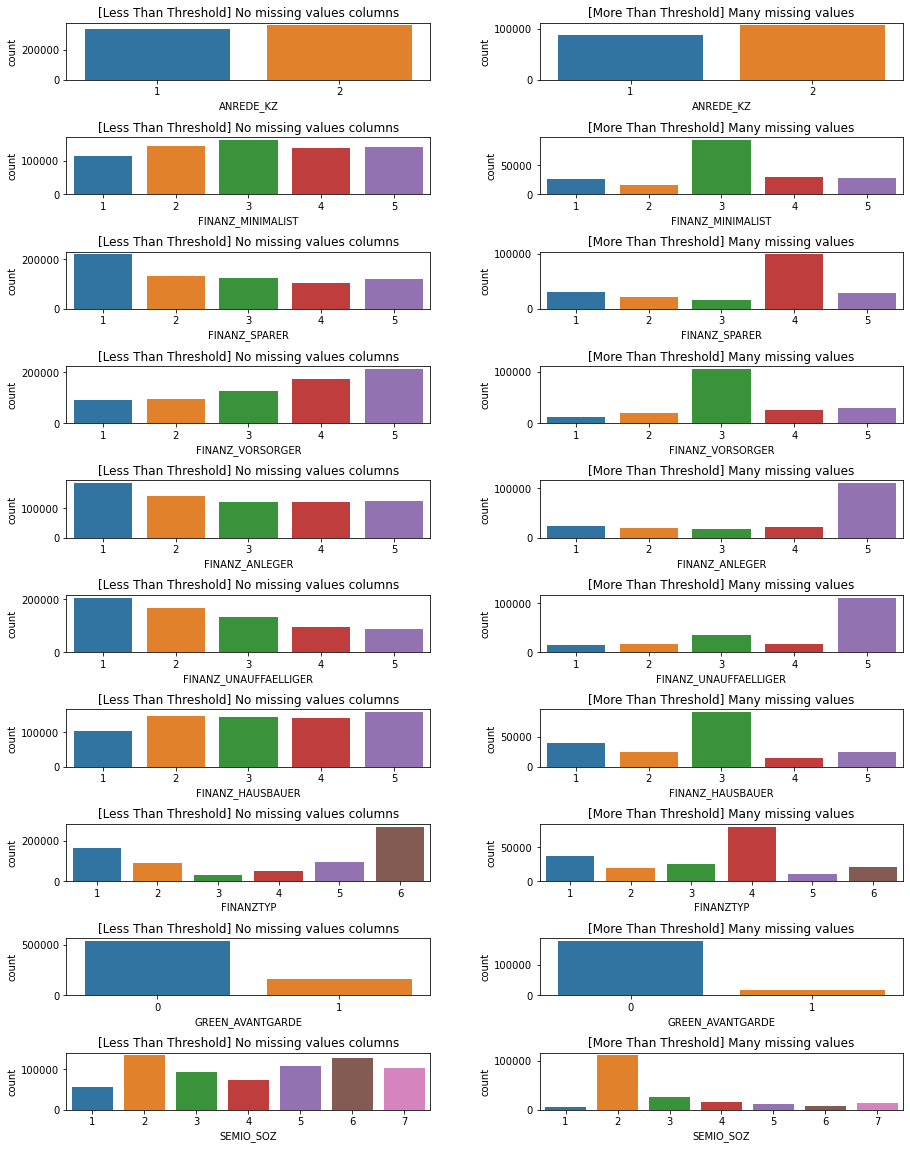

In [86]:
compare_two_subsets(azdias_less_than_threshold, azdias_more_than_threshold, no_missing_value_columns_indices)

In [87]:
# We will update the modified version of azdias to the subset with less missing value
azdias_modified = azdias_less_than_threshold

#### Discussion 1.1.3: Assess Missing Data in Each Row

As we looked in the graphs above, we compared 10 columns in two different subsets of data. One subset contains few or no missing values and the other has so many missing values. We found that the columns that has no missing values has distributed data almost equally between all the columns (not skewed) and it makes sense for the data we need. The missing values subset contains data inequality and skewed data (not helpful and has so many null values).

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [88]:
# How many features are there of each data type?
features = azdias_modified.columns.tolist()

feat_info_for_midified_azdias = feat_info[feat_info['attribute'].isin(features)]

category_count = feat_info_for_midified_azdias['type'].value_counts()

category_count

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [89]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

print('Unique data types list: {}'.format(feat_info_for_midified_azdias['type'].unique()))

categorical_features = feat_info_for_midified_azdias[feat_info_for_midified_azdias['type']=='categorical']['attribute']


Unique data types list: ['ordinal' 'categorical' 'mixed' 'numeric']


In [90]:
def retrieve_binary_and_nonbinary(df, categorical_features):
    binary_features = []
    non_binary_features = []
    
    for categorical_feature in categorical_features:
        if len(df[categorical_feature].unique()) == 2:
            binary_features.append(categorical_feature)
        else:
            non_binary_features.append(categorical_feature)
    
    return binary_features, non_binary_features


In [91]:
binary_features, non_binary_features = retrieve_binary_and_nonbinary(azdias_modified, categorical_features)

print('Binary features are: {}'.format(binary_features))
print('Non-binary features are: {}'.format(non_binary_features))

Binary features are: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
Non-binary features are: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [92]:
azdias_modified.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0


In [93]:
# Re-encode categorical variable(s) to be kept in the analysis.
for binary_feat_name in binary_features:
    attribute_column = azdias_modified[binary_feat_name]
    print('Binary Feature Name: ', binary_feat_name)
    print('Binary Feature Unique Values: ', attribute_column.unique())
    print('')


Binary Feature Name:  ANREDE_KZ
Binary Feature Unique Values:  [2 1]

Binary Feature Name:  GREEN_AVANTGARDE
Binary Feature Unique Values:  [0 1]

Binary Feature Name:  SOHO_KZ
Binary Feature Unique Values:  [1. 0.]

Binary Feature Name:  OST_WEST_KZ
Binary Feature Unique Values:  ['W' 'O']



#### Note:
We found that the feature (OST_WEST_KZ) contains values: ('W' 'O') which are not numbers, so we need to replace them with value numbers (0, 1):
-  O: East (GDR) = 0
-  W: West (FRG) = 1

In [94]:
mapping_values = {'O': 0, 'W': 1}

azdias_modified = azdias_modified.replace({'OST_WEST_KZ':mapping_values})


In [95]:
for non_binary_feat_name in non_binary_features:
    attribute_column = azdias_modified[non_binary_feat_name]
    print('Non-Binary Feature Name: ', non_binary_feat_name)
    print('Non-Binary Feature Unique Values: ', attribute_column.unique())
    print('')


Non-Binary Feature Name:  CJT_GESAMTTYP
Non-Binary Feature Unique Values:  [5. 3. 2. 4. 1. 6.]

Non-Binary Feature Name:  FINANZTYP
Non-Binary Feature Unique Values:  [1 5 2 4 6 3]

Non-Binary Feature Name:  GFK_URLAUBERTYP
Non-Binary Feature Unique Values:  [10.  5.  1. 12.  9.  3.  8. 11.  4.  7.  6.  2.]

Non-Binary Feature Name:  LP_FAMILIE_FEIN
Non-Binary Feature Unique Values:  [ 5.  1. 10.  2.  7. 11.  8.  4.  6.  9.  3.]

Non-Binary Feature Name:  LP_FAMILIE_GROB
Non-Binary Feature Unique Values:  [3. 1. 5. 2. 4.]

Non-Binary Feature Name:  LP_STATUS_FEIN
Non-Binary Feature Unique Values:  [ 2.  3.  4.  1. 10.  8.  9.  5.  6.  7.]

Non-Binary Feature Name:  LP_STATUS_GROB
Non-Binary Feature Unique Values:  [1. 2. 5. 4. 3.]

Non-Binary Feature Name:  NATIONALITAET_KZ
Non-Binary Feature Unique Values:  [ 1.  2. nan  3.]

Non-Binary Feature Name:  SHOPPER_TYP
Non-Binary Feature Unique Values:  [ 3.  2.  0.  1. nan]

Non-Binary Feature Name:  VERS_TYP
Non-Binary Feature Unique Valu

In [96]:
azdias_modified = azdias_modified.drop(columns=['CAMEO_DEU_2015'], axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

We have handled all binary features by setting the missing values as np.nan to handle later using imputer (filling them with data). We kept all binary and non-binary categorical features so we can keep as much data as possible. Also, we found that CAMEO_DEU_2015 is a detailed version of CAMEO_DEUG_2015, so for simplicity, we will eliminate this column from the dataframe.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [97]:
mixed_features = feat_info_for_midified_azdias[feat_info_for_midified_azdias['type']=='mixed']['attribute']

mixed_features

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [98]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

mapping_decade = {
    1: 1, # 40s
    2: 1, # 40s
    3: 2, # 50s
    4: 2, # 50s
    5: 3, # 60s
    6: 3, # 60s
    7: 3, # 60s
    8: 4, # 70s
    9: 4, # 70s
    10: 5, # 80s
    11: 5, # 80s
    12: 5, # 80s
    13: 6, # 80s
    14: 6, # 90s
    15: 6, # 90s
}

mapping_movement = {
    1: 0, # IS_AVANTGARDE
    2: 1, # IS_AVANTGARDE
    3: 0, # IS_AVANTGARDE
    4: 1, # IS_AVANTGARDE
    5: 0, # IS_AVANTGARDE
    6: 1, # IS_AVANTGARDE
    7: 1, # IS_AVANTGARDE
    8: 0, # IS_AVANTGARDE
    9: 1, # IS_AVANTGARDE
    10: 0, # IS_AVANTGARDE
    11: 1, # IS_AVANTGARDE
    12: 0, # IS_AVANTGARDE
    13: 1, # IS_AVANTGARDE
    14: 0, # IS_AVANTGARDE
    15: 1, # IS_AVANTGARDE
}

azdias_modified['DECADE'] = azdias_modified['PRAEGENDE_JUGENDJAHRE']
azdias_modified['IS_AVANTGARDE'] = azdias_modified['PRAEGENDE_JUGENDJAHRE']

azdias_modified['DECADE'] = azdias_modified['DECADE'].replace(mapping_decade)
azdias_modified['IS_AVANTGARDE'] = azdias_modified['IS_AVANTGARDE'].replace(mapping_movement)

azdias_modified.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,IS_AVANTGARDE
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,0.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,1.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,0.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,0.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,5.0,0.0


In [99]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias_modified['HOUSE_HOLD_TYPE'] = azdias_modified['CAMEO_INTL_2015'].str[:1] # From first number we get house hold type
azdias_modified['LIFE_STAGE'] = azdias_modified['CAMEO_INTL_2015'].str[1:] # From second number we get life stage

print('HOUSE_HOLD_TYPE values: ', azdias_modified['HOUSE_HOLD_TYPE'].unique())
print('LIFE_STAGE values: ', azdias_modified['LIFE_STAGE'].unique())


HOUSE_HOLD_TYPE values:  ['5' '2' '4' '1' '3' nan]
LIFE_STAGE values:  ['1' '4' '3' '2' '5' nan]


#### Discussion 1.2.2: Engineer Mixed-Type Features

We have created new features from existing mixed features like (PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015). We will remove all the mixed features as we extracted some of the data we need from them.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [100]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

for mixed_feature_name in mixed_features:
    azdias_modified.drop(mixed_feature_name, axis=1, inplace=True)

azdias_modified.shape

(697109, 76)

In [101]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

print('Null values in all the dataframe: ', azdias_modified.isnull().sum().sum())


Null values in all the dataframe:  181802


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [131]:
# Helper functions to clean data:

mapping_decade = {
    1: 1, # 40s
    2: 1, # 40s
    3: 2, # 50s
    4: 2, # 50s
    5: 3, # 60s
    6: 3, # 60s
    7: 3, # 60s
    8: 4, # 70s
    9: 4, # 70s
    10: 5, # 80s
    11: 5, # 80s
    12: 5, # 80s
    13: 6, # 80s
    14: 6, # 90s
    15: 6, # 90s
}

mapping_movement = {
    1: 0, # IS_AVANTGARDE
    2: 1, # IS_AVANTGARDE
    3: 0, # IS_AVANTGARDE
    4: 1, # IS_AVANTGARDE
    5: 0, # IS_AVANTGARDE
    6: 1, # IS_AVANTGARDE
    7: 1, # IS_AVANTGARDE
    8: 0, # IS_AVANTGARDE
    9: 1, # IS_AVANTGARDE
    10: 0, # IS_AVANTGARDE
    11: 1, # IS_AVANTGARDE
    12: 0, # IS_AVANTGARDE
    13: 1, # IS_AVANTGARDE
    14: 0, # IS_AVANTGARDE
    15: 1, # IS_AVANTGARDE
}

def convert_missing_values_to_nan(df):
    print('\n\n----==============[ Convert Missing Values to NaNs ]==============----')
    for index in range(len(feat_info)):
        # Retrieve data of feat_info with given index
        feature_info_details = feat_info.iloc[index]
        print('Processing for column "{}", with missing values {}'.format(feature_info_details['attribute'], feature_info_details['processed_missing_or_unknown']))

        # Check for any missing values
        # Do not do anything for no missing values
        if feature_info_details['processed_missing_or_unknown'] == []:
            print('No missing value found...')
            continue
        
        df = df.replace({feature_info_details['attribute']: feature_info_details['processed_missing_or_unknown']}, np.nan)
    return df


def remove_selected_rows_and_columns(df):
    print('\n\n----==============[ Removing Selected Rows and Columns ]==============----')
    print('Current shape of dataframe: ', df.shape)
    
    print('Dropping columns: {}'.format(columns_to_be_dropped))
    df = df.drop(columns_to_be_dropped, axis=1)
    
    print('Dropping rows with more than 4 missing values')
    threshold = 4
    df = df[df.isnull().sum(axis=1) <= threshold]
    
    print('Shape of dataframe after removing columns/rows: ', df.shape)
    return df


def select_and_engineer_rows_and_columns(df):
    print('\n\n----==============[ Select and Engineer Rows and Columns ]==============----')
    print('Current shape of dataframe: ', df.shape)
    
    print('Converting "W" and "O" in the column (OST_WEST_KZ) to binary (0, 1) instead')
    df = df.replace({'OST_WEST_KZ':mapping_values})
    print('Dropping the column (CAMEO_DEU_2015) as we do not need redundant data for simplicity')
    df = df.drop(columns=['CAMEO_DEU_2015'], axis=1)
    
    print('Engineering two new columns from existing mixed column (PRAEGENDE_JUGENDJAHRE)')
    
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['IS_AVANTGARDE'] = df['PRAEGENDE_JUGENDJAHRE']
    
    df['DECADE'] = df['DECADE'].replace(mapping_decade)
    df['IS_AVANTGARDE'] = df['IS_AVANTGARDE'].replace(mapping_movement)
    
    print('Engineering another two columns from existing mixed column ()')
    df['HOUSE_HOLD_TYPE'] = df['CAMEO_INTL_2015'].str[:1] # From first number we get house hold type
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].str[1:] # From second number we get life stage
    
    print('Dropping all mixed features in the dataframe')
    for mixed_feature_name in mixed_features:
        df.drop(mixed_feature_name, axis=1, inplace=True)
        
    print('Shape of dataframe after selecting and engineering columns/rows: ', df.shape)
    
    return df


def generate_dummy_variables_for_non_binary_features(df):
    print('\n\n----==============[ Generate Dummy Variables for Non-Binary Features ]==============----')
    print('Current shape of dataframe: ', df.shape)
    
    # Step 2: Convert multi-level categoricals into dummy variables
    for non_binary_feature_name in non_binary_features:
        
        if(non_binary_feature_name == 'CAMEO_DEU_2015'):
            # Ignore this feature as we removed it in a previous step
            continue
        
        # Only get non-null values to generate dummies
        non_null_values = df[non_binary_feature_name][df[non_binary_feature_name].notnull()]
        # Generate dummy attributes for column
        dummies = pd.get_dummies(non_null_values, prefix=non_binary_feature_name)
        # Add dummy attributes
        df = df.join(dummies)
        # Drop column that we extracted from the dummies
        df.drop([non_binary_feature_name], axis=1, inplace=True)
    
    print('Shape of dataframe after generating dummies: ', df.shape)
    
    return df
    

In [132]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # Change missing values to np.nan
    cleaned_dataframe = convert_missing_values_to_nan(df)
    
    # remove selected columns and rows, ...
    cleaned_dataframe = remove_selected_rows_and_columns(cleaned_dataframe)
    
    # select, re-encode, and engineer column values.
    cleaned_dataframe = select_and_engineer_rows_and_columns(cleaned_dataframe)
    
    # generate dummy variables for non-binary features
    cleaned_dataframe = generate_dummy_variables_for_non_binary_features(cleaned_dataframe)
    
    # Return the cleaned dataframe.
    return cleaned_dataframe
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [133]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

cleaned_dataframe = clean_data(azdias)



----==============[ Convert Missing Values to NaNs ]==============----
Processing for column "AGER_TYP", with missing values [-1, 0]
Processing for column "ALTERSKATEGORIE_GROB", with missing values [-1, 0, 9]
Processing for column "ANREDE_KZ", with missing values [-1, 0]
Processing for column "CJT_GESAMTTYP", with missing values [0]
Processing for column "FINANZ_MINIMALIST", with missing values [-1]
Processing for column "FINANZ_SPARER", with missing values [-1]
Processing for column "FINANZ_VORSORGER", with missing values [-1]
Processing for column "FINANZ_ANLEGER", with missing values [-1]
Processing for column "FINANZ_UNAUFFAELLIGER", with missing values [-1]
Processing for column "FINANZ_HAUSBAUER", with missing values [-1]
Processing for column "FINANZTYP", with missing values [-1]
Processing for column "GEBURTSJAHR", with missing values [0]
Processing for column "GFK_URLAUBERTYP", with missing values ['']
Processing for column "GREEN_AVANTGARDE", with missing values ['']
Proce

In [134]:
cleaned_dataframe.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3.0,2,2,4,2,3,5,4,1,2.0,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,3.0,2,2,2,5,3,1,5,0,2.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18,2.0,2,2,4,1,5,4,1,0,2.0,...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [135]:
cleaned_dataframe.shape

(697109, 149)

In [136]:
# Apply feature scaling to the general population demographics data.
from sklearn.impute import SimpleImputer

imputer = SimpleImputer()

imputed_cleaned_dataframe = pd.DataFrame(imputer.fit_transform(cleaned_dataframe))

imputed_cleaned_dataframe.head(10)

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,148
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,1.0,1.0,3.0,3.0,4.0,1.0,3.0,2.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0,1.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3.0,2.0,2.0,4.0,2.0,3.0,5.0,4.0,1.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3.0,2.0,2.0,2.0,5.0,3.0,1.0,5.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,2.0,2.0,2.0,4.0,1.0,5.0,4.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [139]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_cleaned_dataframe = pd.DataFrame(scaler.fit_transform(imputed_cleaned_dataframe))

scaled_cleaned_dataframe.head(5)


,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,148
0,-1.740387,0.969688,-1.522118,1.586768,-1.051497,1.515221,1.047789,1.338667,-0.541398,1.048277,...,2.016610,-0.221987,-0.342581,-0.341737,-0.386702,-0.269396,-0.397692,-0.332875,2.180148,-0.400043
1,0.202361,0.969688,-1.522118,0.906946,-1.772674,-0.546081,0.320028,1.338667,1.847069,1.048277,...,-0.495882,-0.221987,-0.342581,-0.341737,2.596552,-0.269396,-0.397692,-0.332875,-0.460561,-0.400043
2,0.202361,-1.031260,0.680524,0.227123,0.390857,-1.233182,0.320028,-0.838345,-0.541398,1.048277,...,-0.495882,-0.221987,-0.342581,-0.341737,-0.386702,-0.269396,2.524796,-0.332875,-0.460561,-0.400043
3,-1.740387,0.969688,-0.053690,-1.132523,1.112035,-0.546081,-0.407733,1.338667,-0.541398,1.048277,...,-0.495882,-0.221987,-0.342581,-0.341737,-0.386702,-0.269396,-0.397692,-0.332875,2.180148,-0.400043
4,-0.769013,0.969688,-1.522118,1.586768,-1.772674,1.515221,1.047789,-0.112675,-0.541398,-0.288183,...,-0.495882,-0.221987,-0.342581,-0.341737,2.596552,-0.269396,-0.397692,-0.332875,-0.460561,-0.400043


### Discussion 2.1: Apply Feature Scaling

We have cleaned the features from null values and imputed the dataframe using SimpleImputer with the mean strategy. Also, we scaled the data using StandardScaler package to standerdize the dataframe.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [149]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA(n_components=scaled_cleaned_dataframe.shape[1]//2)

pca_cleaned_dataframe = pca.fit_transform(scaled_cleaned_dataframe)

Number of components to reach 75% variance:  52


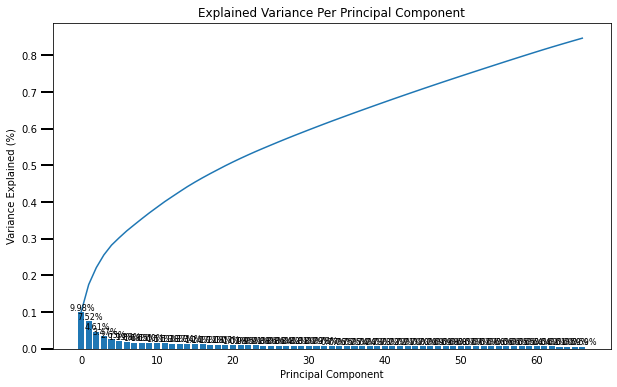

In [152]:
# Investigate the variance accounted for by each principal component.

# Reference of this code can be found in [Lesson 4: Dimensionality Reduction and PCA (Screencast: Interpret PCA Results)]
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)

    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)


def print_required_number_of_components_to_reach_given_variance(pca, variance=85):
    num_components = len(pca.explained_variance_ratio_)
    indices = np.arange(num_components)
    ratios = pca.explained_variance_ratio_
    
    total_percentage = 0.0
    
    for i in range(num_components):
        total_percentage += ratios[i]*100
        
        # Check number of components to reach 85 variance
        if(total_percentage >= variance):
            print('Number of components to reach {}% variance: '.format(variance), i)
            break

print_required_number_of_components_to_reach_given_variance(pca, 75)


In [153]:
# Re-apply PCA to the data while selecting for number of components to retain.

# 52 components gives us variance of 75% for this dataframe
pca = PCA(n_components=52)

pca_cleaned_dataframe = pca.fit_transform(scaled_cleaned_dataframe)

### Discussion 2.2: Perform Dimensionality Reduction


I decided to have 52 principal components as they have 75% variance which is acceptable to me in my opinion. As you can see in the method I made above to calculate required number of components to reach given percentage of variance (75% in this case) and returned to us (52 components).

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [158]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
import operator

def map_principal_component_to_features_and_weights(df, pca, pca_index):
    feature_weight_map = {}
    
    for feature_index, feature_name in enumerate(df.columns):
        feature_weight_map[feature_name] = pca.components_[pca_index][feature_index]
    
    feature_weight_sorted = sorted(feature_weight_map.items(), key=operator.itemgetter(1), reverse=True)
    
    return feature_weight_sorted



map_principal_component_to_features_and_weights(cleaned_dataframe, pca, 0)

[('LP_STATUS_GROB_1.0', 0.19792157004835795),
 ('HH_EINKOMMEN_SCORE', 0.18574265380316393),
 ('PLZ8_ANTG3', 0.181029285044987),
 ('HOUSE_HOLD_TYPE', 0.17993668207873886),
 ('PLZ8_ANTG4', 0.175426799315144),
 ('ORTSGR_KLS9', 0.15349026383482367),
 ('EWDICHTE', 0.1516947834062482),
 ('FINANZ_HAUSBAUER', 0.14337362735476672),
 ('FINANZ_SPARER', 0.12962745857620797),
 ('LP_STATUS_FEIN_1.0', 0.12857030058020236),
 ('KBA05_ANTG4', 0.128337016323664),
 ('PLZ8_ANTG2', 0.12275498781758276),
 ('FINANZTYP_1', 0.12020124970468024),
 ('LP_STATUS_FEIN_2.0', 0.11836464017362004),
 ('KBA05_ANTG3', 0.11808813460072466),
 ('ANZ_HAUSHALTE_AKTIV', 0.11602851853680006),
 ('ARBEIT', 0.11245711999234598),
 ('CAMEO_DEUG_2015_9', 0.11018173665221874),
 ('RELAT_AB', 0.10471851315024082),
 ('SEMIO_PFLICHT', 0.09531665114675364),
 ('DECADE', 0.09237264328621682),
 ('LP_FAMILIE_FEIN_1.0', 0.0899400858205447),
 ('LP_FAMILIE_GROB_1.0', 0.0899400858205447),
 ('SEMIO_REL', 0.08948367641250074),
 ('CAMEO_DEUG_2015_8', 

In [160]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_principal_component_to_features_and_weights(cleaned_dataframe, pca, 1)


[('ALTERSKATEGORIE_GROB', 0.22556842394683446),
 ('FINANZ_VORSORGER', 0.20989663628315275),
 ('ZABEOTYP_3', 0.20011176945060025),
 ('SEMIO_ERL', 0.18120278587000108),
 ('SEMIO_LUST', 0.1587736033696627),
 ('RETOURTYP_BK_S', 0.15814558871539242),
 ('W_KEIT_KIND_HH', 0.13100265718950554),
 ('LP_STATUS_FEIN_1.0', 0.1071046837743632),
 ('CJT_GESAMTTYP_2.0', 0.10194857405522312),
 ('FINANZ_HAUSBAUER', 0.0986594107175871),
 ('FINANZTYP_5', 0.09449317217123133),
 ('SEMIO_KRIT', 0.08351310840092388),
 ('FINANZTYP_2', 0.08183143761384579),
 ('PLZ8_ANTG3', 0.08097271105690726),
 ('PLZ8_ANTG4', 0.0770641723288268),
 ('EWDICHTE', 0.07631733224477588),
 ('ORTSGR_KLS9', 0.07518473447522478),
 ('LP_FAMILIE_FEIN_1.0', 0.0731354544341312),
 ('LP_FAMILIE_GROB_1.0', 0.0731354544341312),
 ('SHOPPER_TYP_3.0', 0.0725080843164708),
 ('HOUSE_HOLD_TYPE', 0.070244974591513),
 ('FINANZ_MINIMALIST', 0.06989807396064718),
 ('CJT_GESAMTTYP_1.0', 0.06736942372033929),
 ('SEMIO_KAEM', 0.06384460653917262),
 ('NATIONA

In [161]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_principal_component_to_features_and_weights(cleaned_dataframe, pca, 2)


[('SEMIO_VERT', 0.3211330382319791),
 ('SEMIO_FAM', 0.2605300857282433),
 ('SEMIO_SOZ', 0.2577467501633314),
 ('SEMIO_KULT', 0.24706012903605473),
 ('FINANZTYP_5', 0.13692631521615406),
 ('FINANZ_MINIMALIST', 0.12885223215265204),
 ('SHOPPER_TYP_0.0', 0.12538257224462407),
 ('SEMIO_REL', 0.11937995049533515),
 ('ZABEOTYP_1', 0.11384359122074754),
 ('RETOURTYP_BK_S', 0.08537289984328479),
 ('SEMIO_MAT', 0.08362379922640473),
 ('W_KEIT_KIND_HH', 0.07297258084149755),
 ('IS_AVANTGARDE', 0.0715577071478335),
 ('GREEN_AVANTGARDE', 0.07131226395759002),
 ('EWDICHTE', 0.06416131713677387),
 ('ORTSGR_KLS9', 0.06340651630350376),
 ('ZABEOTYP_6', 0.05098407299942813),
 ('FINANZ_VORSORGER', 0.04951220890774477),
 ('PLZ8_ANTG4', 0.04942891840150594),
 ('LP_STATUS_FEIN_10.0', 0.04915765578442004),
 ('LP_STATUS_GROB_5.0', 0.04915765578442004),
 ('PLZ8_ANTG3', 0.049064243411149455),
 ('LP_STATUS_FEIN_1.0', 0.04594614184815961),
 ('LP_STATUS_FEIN_3.0', 0.044359606996350706),
 ('SHOPPER_TYP_1.0', 0.042

### Discussion 2.3: Interpret Principal Components

Let's see the three principal components we investigated above.

#### The first principal component:
- Positive Values:
    - *LP_STATUS_GROB_1.0* (Social status, rough scale): 0.19792157004835795
    - *HH_EINKOMMEN_SCORE* (Estimated household net income): 0.18574265380316393
- Negative Values:
    - *FINANZ_MINIMALIST* (Minimalist financial typology): -0.20018860400370223
    - *MOBI_REGIO* (Movement patterns): -0.20716916613447978

#### The second principal component:
- Positive Values:
    - *ALTERSKATEGORIE_GROB* (Estimated age based on given name analysis): 0.22556842394683446
    - *FINANZ_VORSORGER* (VORSORGER financial typology): 0.20989663628315275
- Negative Values:
    - *FINANZ_SPARER* (SPARER financial typology): -0.2171505771697136
    - *DECADE* (Decade of youth): -0.22902889756620703


#### The third principal component:
- Positive Values:
    - SEMIO_VERT (Personality typology): 0.3211330382319791
    - SEMIO_FAM (Personality typology): 0.2605300857282433
- Negative Values:
    - SEMIO_KAEM (Personality typology): -0.31594605620798644
    - ANREDE_KZ (Gender): -0.3460414020724194

    

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [162]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans

def get_kmeans_score(df, center):
    # Used n_jobs=-1 to maximize the use of CPU (to increase speed)
    kmeans = KMeans(n_clusters=center, n_jobs=-1)
    # run k-means clustering on the data and...
    kmeans_model = kmeans.fit(df)

    # compute the average within-cluster distances.
    kmeans_score = np.abs(kmeans_model.score(df))

    return kmeans_score


In [165]:
import time

scores = []


centers = list(range(2, 15, 2))
start_time = time.time()

for center in centers:
    score = get_kmeans_score(pca_cleaned_dataframe, center)
    end_time = time.time()
    print('Center [{}] - Score [{}] - Time [{}]'.format(
        center,
        score,
        str(round(end_time-start_time, 2)) + ' seconds'
    ))
    scores.append(score)


C:\Users\Abdulmajeed\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Center [2] - Score [69608392.07381414] - Time [6.24 seconds]


C:\Users\Abdulmajeed\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Center [4] - Score [63025970.20945895] - Time [17.83 seconds]


C:\Users\Abdulmajeed\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Center [6] - Score [59564903.595449306] - Time [33.55 seconds]


C:\Users\Abdulmajeed\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Center [8] - Score [57462756.65948086] - Time [60.37 seconds]


C:\Users\Abdulmajeed\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Center [10] - Score [55208960.98010745] - Time [88.12 seconds]


C:\Users\Abdulmajeed\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Center [12] - Score [53904089.106621735] - Time [126.02 seconds]


C:\Users\Abdulmajeed\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Center [14] - Score [52708890.99233263] - Time [166.01 seconds]


Text(0.5, 1.0, 'SSE vs. K')

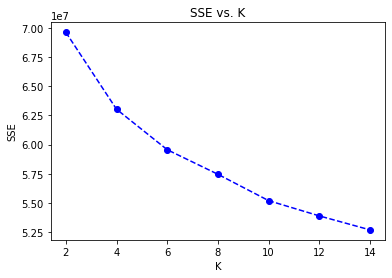

In [166]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')

As you can see, the plot starting to flatten out after approximately (10), I think I will take 11 as the "elbow"

In [168]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=11)
model_general_population = kmeans.fit(pca_cleaned_dataframe)
predict_general_population = kmeans.predict(pca_cleaned_dataframe)

### Discussion 3.1: Apply Clustering to General Population

I have decided to cluster them in 11 clusters, as I noticed that the elbow might be 11. This cluster will help  us identify segments of people and we can compare them with the customers clusters and get list of possible customers.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [182]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
cleaned_customers = clean_data(customers)



----==============[ Convert Missing Values to NaNs ]==============----
Processing for column "AGER_TYP", with missing values [-1, 0]
Processing for column "ALTERSKATEGORIE_GROB", with missing values [-1, 0, 9]
Processing for column "ANREDE_KZ", with missing values [-1, 0]
Processing for column "CJT_GESAMTTYP", with missing values [0]
Processing for column "FINANZ_MINIMALIST", with missing values [-1]
Processing for column "FINANZ_SPARER", with missing values [-1]
Processing for column "FINANZ_VORSORGER", with missing values [-1]
Processing for column "FINANZ_ANLEGER", with missing values [-1]
Processing for column "FINANZ_UNAUFFAELLIGER", with missing values [-1]
Processing for column "FINANZ_HAUSBAUER", with missing values [-1]
Processing for column "FINANZTYP", with missing values [-1]
Processing for column "GEBURTSJAHR", with missing values [0]
Processing for column "GFK_URLAUBERTYP", with missing values ['']
Processing for column "GREEN_AVANTGARDE", with missing values ['']
Proce

In [183]:
for population_column in cleaned_dataframe.columns:
    
    if(population_column not in cleaned_customers.columns):
        print('We do not have this column in the customers dataframe: ', population_column)
        print('We need to add the column {} with values = Zeros by default'.format(population_column))
        cleaned_customers[population_column] = 0


We do not have this column in the customers dataframe:  GEBAEUDETYP_5.0
We need to add the column GEBAEUDETYP_5.0 with values = Zeros by default


In [184]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# null_values_columns_for_customers = cleaned_customers.columns[cleaned_customers.isna().any()].tolist()

print('Null values for customers: ', cleaned_customers.isnull().sum().sum())

# for null_values_column in null_values_columns_for_customers
cleaned_customers = pd.DataFrame(imputer.transform(cleaned_customers))

print('Null values for customers after imputing: ', cleaned_customers.isnull().sum().sum())



Null values for customers:  32593
Null values for customers after imputing:  0


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [185]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
scaled_cleaned_customers = pd.DataFrame(scaler.transform(cleaned_customers))
pca_cleaned_customers = pd.DataFrame(pca.transform(scaled_cleaned_customers))
customers_prediction = model_general_population.predict(pca_cleaned_customers)


Text(0.5, 1.0, 'Customer Predicted Clusters')

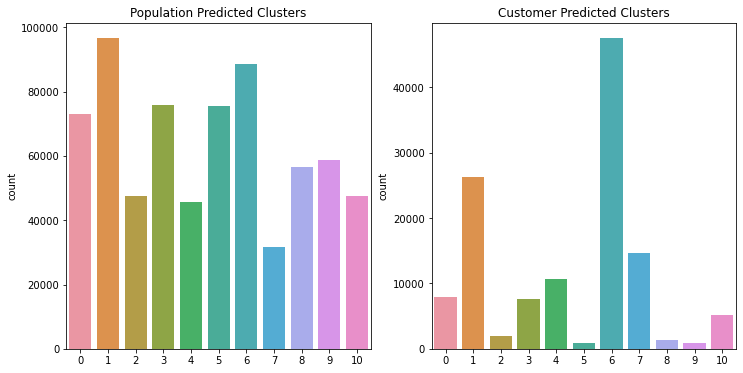

In [194]:
# Show figures to compare both clusters

figure, axs = plt.subplots(nrows = 1, ncols = 2, figsize= (12,6))

sns.countplot(predict_general_population, ax=axs[0])
axs[0].set_title('Population Predicted Clusters')

sns.countplot(customers_prediction, ax=axs[1])
axs[1].set_title('Customer Predicted Clusters')

In [222]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Retrieve details of cluster 6 for the general population that is overrepresented in customers clusters
cluster_6 = scaler.inverse_transform(pca.inverse_transform(model_general_population.cluster_centers_[6]))
overpresented = pd.Series(cluster_6, index = cleaned_dataframe.columns)
overpresented.index = cleaned_dataframe.columns

In [234]:
for index in overpresented.sort_values(ascending=False).index:
    print(index, '\t\t', overpresented[index])

MIN_GEBAEUDEJAHR 		 1992.6882143433547
KBA13_ANZAHL_PKW 		 693.0987468061422
WOHNDAUER_2008 		 8.601618014855527
SEMIO_LUST 		 5.164196621176626
ORTSGR_KLS9 		 5.158706473424625
SEMIO_ERL 		 5.151912743819527
INNENSTADT 		 4.782415058165242
SEMIO_DOM 		 4.7292582958561695
SEMIO_VERT 		 4.626153347278711
FINANZ_MINIMALIST 		 4.568334185311995
SEMIO_KRIT 		 4.385865734166875
MOBI_REGIO 		 4.295230270066335
SEMIO_KAEM 		 4.257070270324437
BALLRAUM 		 4.210412293996899
KBA05_GBZ 		 4.188671867982553
FINANZ_VORSORGER 		 4.1531291002052955
GEBAEUDETYP_RASTER 		 4.077344734424222
SEMIO_SOZ 		 4.05380073354724
W_KEIT_KIND_HH 		 3.935214232149771
PLZ8_GBZ 		 3.9197027960726594
EWDICHTE 		 3.827999956021307
DECADE 		 3.6644731906606633
RETOURTYP_BK_S 		 3.663407634744854
PLZ8_HHZ 		 3.6564777087106908
LIFE_STAGE 		 3.6089898980709796
SEMIO_KULT 		 3.561354712252813
REGIOTYP 		 3.557867845052636
KONSUMNAEHE 		 3.4959432930843177
SEMIO_FAM 		 3.459711919718063
ALTERSKATEGORIE_GROB 		 3.31160474292

In [226]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_5 = scaler.inverse_transform(pca.inverse_transform(model_general_population.cluster_centers_[5]))
underrepresented = pd.Series(cluster_5, index = cleaned_dataframe.columns)


In [235]:
for index in underrepresented.sort_values(ascending=False).index:
    print(index, '\t\t', underrepresented[index])

MIN_GEBAEUDEJAHR 		 1992.285954308614
KBA13_ANZAHL_PKW 		 545.127144666126
ANZ_HAUSHALTE_AKTIV 		 14.137950453379531
WOHNDAUER_2008 		 7.132089881441094
ORTSGR_KLS9 		 6.711228021703237
SEMIO_DOM 		 6.2477092748818865
SEMIO_RAT 		 6.208644278322545
SEMIO_PFLICHT 		 6.171087729182744
SEMIO_KAEM 		 6.1660636137127165
DECADE 		 5.749345130745847
SEMIO_TRADV 		 5.7383176540438035
HH_EINKOMMEN_SCORE 		 5.616300742291573
SEMIO_KRIT 		 5.455356965430411
SEMIO_REL 		 5.243966905350437
EWDICHTE 		 4.967071220122093
REGIOTYP 		 4.850321806001129
SEMIO_MAT 		 4.7801991738787235
FINANZ_SPARER 		 4.414222926524187
FINANZ_ANLEGER 		 4.324727528857974
FINANZ_HAUSBAUER 		 4.294961199694718
HOUSE_HOLD_TYPE 		 4.246654881372091
SEMIO_ERL 		 4.195728634539635
SEMIO_KULT 		 4.097735503271179
W_KEIT_KIND_HH 		 3.975793903638418
SEMIO_FAM 		 3.812510057049226
PLZ8_HHZ 		 3.7692035326878837
FINANZ_UNAUFFAELLIGER 		 3.757059852456722
RELAT_AB 		 3.625809608347587
ARBEIT 		 3.6188871663676445
INNENSTADT 		 3.6

In [236]:
feat_info[feat_info['attribute'] == 'KBA05_ANTG1']

,attribute,information_level,type,missing_or_unknown,processed_missing_or_unknown
60,KBA05_ANTG1,microcell_rr3,ordinal,[-1],[-1]


### Discussion 3.3: Compare Customer Data to Demographics Data


Based on our analysis above, we found that there are many factors affects the possibility that a person might become a customer for mail-order company. For example, we found that the if the length of residense for a person is around 9 years, they might be interested in subscriping to mail-order company. Also, if the house hold is an old family and mature couples they are most likely to be popular with mail-order. Moreover, if they are living in a building with less than or equal to 2 households, they will have a higher chance of being popular with the mail-order. Also, if they were with highly active movements, they will be more popular with the mail-order.

On the other hand, the people who are probably not popular with mail-order company would be living in a building with more than 13 households and their length or residense is between 6 and 7 years. Another variable that might be considered an alarm that the person might not be popular with the mail-order is that their youth decade was in the 80s and 90s. 

As you can see, segmentation made simple using unsupervised learning algorithm! It might be used to target group of people to market a company's product for example. I would consider using it if I ever had the chance.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.